# Imputação, Outcome Regression, and Doubly Robust Estimation

Prof. Daniel de Abreu Pereira Uhr

## Conteúdo

* Estimadores Baseados em Imputação
  * Aplicação no Python
* Outcome Regression
  * Aplicação no Python
* Doubly Robust Estimation
  * Aplicação no Python
* Boas Práticas


## Referências

* Heckman, James, Hidehiko Ichimura, Jefrey Smith, and Petra Todd. (1998). Characterizing selection bias using experimental data". Econometrica 66.5, pp. 1017-1098.
* Cunningham, S. W. (2013). Causal inference: The mixtape. https://www.scunning.com/mixtape.html
* Courthoud, Matteo. Understanding AIPW. https://matteocourthoud.github.io/post/aipw/ 
* Matheus Facure. Doubly Robust Estimation. https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html
* Pearl, J. (2000). Causality: Models, reasoning, and inference. Cambridge University Press.
* Joshua D. Angrist and Jörn-Steffen Pischke (2009). Mostly Harmless Econometrics: An Empiricist's Companion. Princeton University Press.
* Morgan, S. L., & Winship, C. (2014). Counterfactuals and causal inference: Methods and principles for social research. Cambridge University Press. Capítulo 3.

**Pacotes Python**
* pyDRReg - Regressão Duplamente Robusta, Outcome Regression e Inverse Probability Weighting, com erro padrão bootstrap.
* Instalação: `pip install git+https://github.com/Daniel-Uhr/pyDRReg.git`

## Introdução

Lembre que nossa busca é a identificação do parâmetro causal. Devido ao **problema fundamental da inferência causal**: 

$$ Y_{i} = D Y^{1}_{i} + (1-D)Y^{0}_{i} $$

rearrajando a equação, temos:

$$ Y_{i} = Y^{0}_{i} + (Y^{1}_{i} - Y^{0}_{i})D $$

Essa segunda equação nos oference "insights" importantes, repare que $(Y^{1}_{i} - Y^{0}_{i})$ é o efeito do tratamento no nível do indivíduo, chamaos isso de ***Individual Treatment Effect***. Vamos definir o ITE como $\tau_{i}$.

$$ Y_{i} = Y^{0}_{i} + \tau_{i} D $$

A interpretação direta é que o resultado do individuo *i* será o estado da natureza de não tratado ($Y^{0}$) mais (ou menos) o efeito do tratamento individual ($\tau_{i}$), caso o indivíduo seja tratado ($D=1$). Essa estrutura é fundamentada na consideração explicita do contrafactual (temos os dois estados do mundo considerados para cada indivíduo).

***Estrutura dos Dados Reais***

A prática do problema fundamental da inferencia causal é que não podemos observar o resultado de um indivíduo sendo tratado e não-tratado simultaneamente. Logo, nossa estrutura de dados implica em **dados faltante**. Um dos estados da natureza está "faltante no nosso banco de dados.

Vamos considerar um exemplo simples para ilustrar o problema. Suponha que temos um conjunto de dados com as seguintes variáveis:


| Unidade |   $Y^{1}$     |  $Y^{0}$     | $D$      |  $X $    |
|---------|--------|-------|--------|-------|
| 1       | 5      |       | 1      | 11    |
| 2       | 2      |       | 1      | 7     |
| 3       | 10     |       | 1      | 5     |
| 4       | 6      |       | 1      | 3     |
| 5       |        | 4     | 0      | 10    |
| 6       |        | 0     | 0      | 8     |
| 7       |        | 5     | 0      | 4     |
| 8       |        | 1     | 0      |  1    |


Repare que quando os indivíduos são tratados ($D=1$), não temos os resultados para o indivíduo no estado da natureza de não tratado ($Y^{0}$). O mesmo ocorre quando os indivíduos são nâo tratados ($D=0$), então não observamos o seus respectivos resultados caso "tivessem sido tratados" ($Y^{1}$).

Processo de completar esses dados faltantes é chamado de imputação.


### Regressão Linear

Mas se desconsiderarmos o ***problema fundamental da inferência causal***, e calculássemos uma regressão linear? 

Repare na estrutura de uma estimação linear:

$$ Y = \alpha + \beta D + \epsilon $$

(ela não é parecida com alguma coisa que vimos recentemente?)

A interpretação geral da regressão linear é o seguinte, o valor de $Y$ é composto por um valor constante ($\alpha$) mais um valor $\beta$ que é adicionado quando D é um, mais um choque.

De outra forma, vamos desagregar Y entre os dois grupos definidos por D.

$$ E[Y | D=0 ] = \alpha $$

$$ E[Y | D=1 ] = \alpha + \beta $$

Voce reparou que há uma semelhança com a estrutura de identificação do efeito ITE? Entretanto não é igual...

In [1]:
import pandas as pd
import statsmodels.formula.api as smf 
# DataFrame
df = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/training_bias_reduction.dta")

Repare que na coluna dos resultados ($Y$), temos tanto ($Y^{1}$ quanto $Y^{0}$).

In [2]:
df

Unit   Y  D   X
0     1   5  1  11
1     2   2  1   7
2     3  10  1   5
3     4   6  1   3
4     5   4  0  10
5     6   0  0   8
6     7   5  0   4
7     8   1  0   1

Em vez de rodar a regressão, vamos encontrar os parâmetros através das médias. Que tal fazermos na mão?

* $E[Y | D = 0 ] = (4 + 0 + 5 + 1)/4 = 10/4 = 2,5 $
* $E[Y | D = 1 ] = (5 + 2 + 10 + 6) / 4 = 23/4 = 5,75 $

E a difereça entre as médias (SDO) é dada por:

$$ \beta_{OLS} = E[Y | D = 1 ] - E[Y | D = 0 ] $$

* $\beta_{OLS} = 5,75 - 2,5 = 3,25 $


Logo, 

$$ Y = 2,5 + 3,25 D + \epsilon $$

Vamos testar na regressão?

In [4]:
reg0 = smf.ols('Y ~ D', data=df).fit()
print(reg0.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2.548
Date:                sex, 08 ago 2025   Prob (F-statistic):              0.162
Time:                        16:52:55   Log-Likelihood:                -18.662
No. Observations:                   8   AIC:                             41.32
Df Residuals:                       6   BIC:                             41.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5000      1.440      1.736      0.1

Nossa conclusão é que a regressão linear realmente pode ser interpretada como uma diferença de médias. 

Do ponto de vista da identificação do efeito causal, a regressão não garante o real efeito porque estamos aplicando uma diferença entre as médias dos tratados contra o grupo não tratado.

Para encontrarmos o efeito causal, temos que ter em mente a questão de considerar o "contrafactual". Uma solução seria estimadores baseados em imputação.

## Estimadores baseados em Imputação

Estimadores baseados em imputação são métodos estatísticos que lidam com a ausência de dados ou informações não observadas, preenchendo esses valores faltantes com estimativas calculadas a partir dos dados disponíveis. 

Considerando o exemplo anterior:

| Unidade |   $Y^{1}$     |  $Y^{0}$     | $D$      |  $X $    |
|---------|--------|-------|--------|-------|
| 1       | 5      |   ?    | 1      | 11    |
| 2       | 2      |   ?    | 1      | 7     |
| 3       | 10     |   ?    | 1      | 5     |
| 4       | 6      |   ?    | 1      | 3     |
| 5       |   ?     | 4     | 0      | 10    |
| 6       |   ?     | 0     | 0      | 8     |
| 7       |   ?     | 5     | 0      | 4     |
| 8       |   ?     | 1     | 0      |  1    |



* ITE
Para estimar o ITE para cada i.

* ATE

* Generalizando a regressão quando há covariáveis






Para a inferência causal, nos deparamos com **dados faltantes**, principalmente, devido ao **problema fundamental da inferência causal**: não podemos observar o resultado de um indivíduo sob tratamento e controle simultaneamente. Portanto, **não podemos observar o efeito causal de um tratamento em um indivíduo**. O que podemos observar são os resultados de um indivíduo tratado ou não-tratado, mas não em ambos.

$$ Y_{i} = D Y^{1}_{i} + (1-D)Y^{0}_{i} $$

rearrajando a equação, temos:

$$ Y_{i} = Y^{0}_{i} + (Y^{1}_{i} - Y^{0}_{i})D $$

Vamos chamar o efeito causal individual (Individual Treatment Effect - ITE) é a diferença nos dois estados da natureza, que vamos denotar aqui como $\tau_{i}$, então:

$$ Y_{i} = Y^{0}_{i} + \tau_{i} D $$


Quando possuímos uma amostra, podemos avaliar na média. Se calcularmos a média de $Y_{i}$, temos:

$$ E[Y_{i}] = E[Y^{0}_{i}] + E[\tau_{i}]E[D] $$

E as médias condicionais:

$$ E[Y_{i}|D=1] = E[Y^{1}_{i}] = E[Y^{0}_{i}] + E[\tau_{i}] $$

$$ E[Y_{i}|D=0] = E[Y^{0}_{i}] $$

Considere  $\mu_{0}$ a média dos resultados potenciais de controle, e $\mu_{1}$ a média dos resultados potenciais de tratamento. Então:

$$ E[Y_{i}] = \mu_{0} + \tau E[D] $$

$$ E[Y_{i}|D=1] = \mu_{0} + \tau = \mu_{1}$$

$$ E[Y_{i}|D=0] = \mu_{0} $$


Considerando $\mu_{0}$ é a média dos resultados potenciais sob controle e $\epsilon$ o erro:

Mas lembre-se que o modelo de regressão linear podemos controlar por covariáveis. Então podemos considerar o modelo linear dado por:

$$ Y = \alpha + \tau D + \gamma X + \epsilon $$

Continuamos considerando $ Y $ como a variável dependente, $ D $ é a variável indicadora de tratamento (1 se o tratamento foi aplicado, 0 caso contrário), $ X $ são as covariáveis observáveis, e $ \epsilon $ é o termo de erro do modelo.

Agora, repare que se aplicamos a expectativa condicional de $Y$ em $D$, temos:
   
$$ E[Y|X, D=1] = \mu_{1}(X) +  u_1  $$

$$ E[Y|X, D=0] = \mu_{0}(X) + u_0  $$

É importante notar que agora tanto $\mu_{0}$ quanto $\mu_{1}$ são função de $X$, suas características observáveis. E $\mu_{1}(X) $ e $ \mu_{0}(X) $ representam as **médias dos resultados potenciais** para os tratados e não tratados, respectivamente, dados $ X $. Os termos $ u_1 $ e $u_0 $ são termos de erro associados aos grupos de tratamento e controle, respectivamente.


Voltando ao nosso objetivo inicial. Queremos é estimar o efeito causal, como o efeito médio do tratamento (Average Treatment Effect, ATE), definido como:

$$ATE = E[Y_{i}^{1} - Y_{i}^{0}]$$

**Como calcular o ATE?**

Devido à falta de observação simultânea de $Y^{1}$ e $Y^{0}$ para a mesma unidade, os pesquisadores propuseram utilizar **estimadores baseados em imputação** para estimar o potencial resultado não observado.

A ideia é que podemos estimar o ATE a partir de valores previstos dos resultados potenciais sob tratamento ($\hat{Y^{1}}$) e não-tratado ($\hat{Y^{0}}$).


**Exemplo aplicado**


In [17]:
import pandas as pd
import statsmodels.formula.api as smf 
# DataFrame
df = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/training_bias_reduction.dta")
reg1 = smf.ols('Y ~ X', data=df[df['D'] == 1]).fit()
print(reg1.summary())
df['Yhat_1']= reg1.predict(df)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                 -0.296
Method:                 Least Squares   F-statistic:                    0.3157
Date:                Wed, 06 Nov 2024   Prob (F-statistic):              0.631
Time:                        17:10:49   Log-Likelihood:                -9.5879
No. Observations:                   4   AIC:                             23.18
Df Residuals:                       2   BIC:                             21.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0714      4.540      1.778      0.2

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [18]:
reg0 = smf.ols('Y ~ X', data=df[df['D'] == 0]).fit()
print(reg0.summary())

df['Yhat_0']= reg0.predict(df)
df

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.478
Method:                 Least Squares   F-statistic:                   0.03001
Date:                Wed, 06 Nov 2024   Prob (F-statistic):              0.878
Time:                        17:10:53   Log-Likelihood:                -8.5398
No. Observations:                   4   AIC:                             21.08
Df Residuals:                       2   BIC:                             19.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0872      2.788      0.749      0.5

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Unit   Y  D   X    Yhat_1    Yhat_0
0     1   5  1  11  4.142857  2.876923
1     2   2  1   7  5.571429  2.589744
2     3  10  1   5  6.285714  2.446154
3     4   6  1   3  7.000000  2.302564
4     5   4  0  10  4.500000  2.805128
5     6   0  0   8  5.214286  2.661538
6     7   5  0   4  6.642857  2.374359
7     8   1  0   1  7.714286  2.158974

Agora podemos calcular o efeito médio do tratamento (ATE) nos valores previstos de $Y^{1}$ e $Y^{0}$, e então estimar o efeito médio do tratamento.

$$ \hat{ATE} = \frac{1}{N} \sum_{i=1}^{N} \left( \hat{Y}_{i}^{1} - \hat{Y}_{i}^{0} \right) $$


In [21]:
df['tau_hat'] = df['Yhat_1'] - df['Yhat_0']
df

Unit   Y  D   X    Yhat_1    Yhat_0   tau_hat
0     1   5  1  11  4.142857  2.876923  1.265934
1     2   2  1   7  5.571429  2.589744  2.981685
2     3  10  1   5  6.285714  2.446154  3.839560
3     4   6  1   3  7.000000  2.302564  4.697436
4     5   4  0  10  4.500000  2.805128  1.694872
5     6   0  0   8  5.214286  2.661538  2.552747
6     7   5  0   4  6.642857  2.374359  4.268498
7     8   1  0   1  7.714286  2.158974  5.555311

In [ ]:
ATE = df['tau_hat'].mean()
print(f"\nEfeito Médio do Tratamento (ATE) estimado: {ATE}")


Efeito Médio do Tratamento (ATE) estimado: 3.3570054945054957


**E o ATT e o ATC?**

Podemos também estimar o efeito médio do tratamento para os tratados (ATT) e o efeito médio do tratamento para os não tratados (ATU), que são definidos como:

$$ATT = E[Y_{i}^{1} - Y_{i}^{0} | D = 1]$$

$$ATU = E[Y_{i}^{1} - Y_{i}^{0} | D = 0]$$



In [25]:
# Calculando o ATT (média dos tau_hat para D=1)
ATT = df[df['D'] == 1]['tau_hat'].mean()

# Calculando o ATU (média dos tau_hat para D=0)
ATU = df[df['D'] == 0]['tau_hat'].mean()

In [27]:
# Exibindo os resultados
print(f"Efeito Médio do Tratamento (ATE): {ATE}")
print(f"Efeito Médio do Tratamento sobre os Tratados (ATT): {ATT}")
print(f"Efeito Médio do Tratamento sobre os Controles (ATU): {ATU}")

Efeito Médio do Tratamento (ATE): 3.3570054945054957
Efeito Médio do Tratamento sobre os Tratados (ATT): 3.1961538461538472
Efeito Médio do Tratamento sobre os Controles (ATU): 3.517857142857144


**Interpretação dos Resultados**

* **ATE (Efeito Médio do Tratamento):** Estimado em aproximadamente 3.36, indica o efeito médio esperado do tratamento na população geral.

* **ATT (Efeito Médio sobre os Tratados):** Estimado em aproximadamente 3.20, sugere que, para as unidades que receberam o tratamento, o efeito médio do tratamento é um aumento de 3.20 unidades em Y.

* **ATU (Efeito Médio sobre os Não-Tratados)**: Estimado em aproximadamente 3.52, indica que, se as unidades de controle tivessem recebido o tratamento, o efeito médio esperado seria um aumento de 3.52 unidades em Y.

## Outcome Regression

O estimador de "Outcome Regression" também é conhecido como Regression Adjustment ou Augmented Regression. É um desdobramento do estimador de imputação visto no exemplo anterior. Vejamos mais a fundo.

**Outcome Regression - ATE**

Logo, no contexto de resultados potenciais, poderíamos recuperar o efeito causal $\tau$ ao tirarmos e expectativa da diferença de médias. Ou seja:

$$ \hat{ATE} = E[\hat{Y}^{1} - \hat{Y}^{0}] $$


$$ \hat{ATE} = E[ (\mu_{1}(X) +  u_1) - (\mu_{0}(X) - u_0) ] $$

$$ \hat{ATE} = E[\mu_{1}(X) - \mu_{0}(X)] - E[u_1 - u_0] $$


Em um experimento controlado, esperaríamos que:
* $E[Y_{1} - \mu_{1}(X)] = E[u_{1}] = 0$ 
* $E[Y_{0} - \mu_{0}(X)] = E[u_{0}] = 0$

o que simplificaria a expressão para o efeito causal médio ajustado pelas covariáveis: 

$$ \hat{ATE} = E[\mu_{1}(X)- \mu_{0}(X)] - E[u_1 - u_0] = E[\beta] $$

em outras palavras, em caso de um experimento, a expressão para o ATE, ajustado pelas covariáveis, deve simplificar para

$$ \hat{\beta}^{OR}_{ATE} = E[\mu_{1}(X)- \mu_{0}(X)] $$

Uma proposta natural para estimar as funções $\mu_{1}(X)$ e $\mu_{0}(X)$ é ajustar um modelo de regressão linear para $Y$ em função de $D$ e $X$. Se o modelo for **corretamente especificado**, o coeficiente de $D$ estimado será uma estimativa consistente do efeito causal médio ajustado pelas covariáveis.

Logo, os *pressupostos principais* para identificação do efeito causal:

* **Linearidade**
* **Viés de seleção por observáveis** (ignorabilidade condicional)
  * Assumimos que, ao incluir $X$ no modelo, estamos controlando adequadamente por todas as fontes de viés de seleção.

**Limitações:**
* Se existirem variáveis não observadas que afetam $D$ e $Y$, o estimador de Outcome Regression será enviesado.


**Outcome Regression - ATT**

Para obter o efeito médio do tratamento para os tratados, utilizamos a ideia contrafactual, para o subgrupo amostral dos tratados. A ideia é utilizar a projeção do grupo Não-tratado com as características X do grupo de tratamento ($X^{1}$) para construir o contrafactual. 

Queremos construir um grupo de controle, sua função ($\mu_{0}(.)$ representa como os não-tratados se comportam, entretanto projetamos seu resultado contrafactual ao considerar "se eles tivessem as características observáveis dos tratados").

Dessa forma a estimativa do efeito médio do tratamento para os tratados (ATT) é dada por:

$$ \hat{\beta}^{OR}_{ATT} = E[\mu_{1}(X^{1}) - \mu_{0}(X^{1})] + E[(Y_{1} - \mu_{1}(X^{1})) - (Y_{0} - \mu_{0}(X^{1}))] $$


Em outras palavras, consideramos os resultados do grupo de controle caso eles tivessem as mesmas características observáveis do grupo de tratamento.

Como no exemplo anterior, isso ocorre na subamostra dos tratados, ou seja, quando restringimos a análise em $D=1$.

### Aplicação no Python	

Vamos fazer um exemplo prático no Python, com os dados das mães fumantes e não fumantes durante a gestação, e o peso dos bebês ao nascer. 

Primeiramente farei os códigos na "mão", e depois utilizarei o pacote pyDRReg.


In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [29]:
# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

# Criar variáveis de controle
df['Mmarried'] = 0
df.loc[df['mmarried'] == 'married', 'Mmarried'] = 1
df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

Após carregar os dados vamos tentar aplicar o Outcome Regression para estimar o ATE.

```python

**Outcome Regression - ATE**

In [30]:
def OR_ate(df, X_cols, T_col, Y_col):
    X_np = df[X_cols].values  # Converter X para numpy array
    T_np = df[T_col].values  # Converter T para numpy array
    Y_np = df[Y_col].values  # Converter Y para numpy array
    # Essas linhas convertem as colunas de interesse do DataFrame (df) em arrays numpy, o que facilita a manipulação e os cálculos subsequentes.
        
    # Ajustar regressão linear para não tratados (D=0)
    model_0 = LinearRegression().fit(X_np[T_np==0], Y_np[T_np==0])
    mu0 = model_0.predict(X_np)
    # Aqui, ajusta-se um modelo de regressão linear para as observações que não receberam o tratamento (T_np == 0). Em seguida, são feitas previsões (mu0) para todas as observações com base neste modelo.
    
    # Ajustar regressão linear para tratados (D=1)
    model_1 = LinearRegression().fit(X_np[T_np==1], Y_np[T_np==1])
    mu1 = model_1.predict(X_np)
    # Da mesma forma, ajusta-se um modelo de regressão linear para as observações que receberam o tratamento (T_np == 1) e são feitas previsões (mu1) para todas as observações com base neste modelo.
    
    # Calcular o efeito causal médio
    effect = np.mean(mu1 - mu0)
    # Calcula-se a diferença média entre as previsões dos modelos para tratados e não tratados, resultando em uma estimativa preliminar do efeito causal médio
    
    # Calcular os desvios para todas as observações
    deviations = (Y_np - (T_np * mu1 + (1 - T_np) * mu0))
    # Os desvios são calculados como a diferença entre os valores observados de Y e as previsões ponderadas dos modelos de tratados e não tratados.
    
    # Calcular a média dos desvios
    deviations_mean = np.mean(deviations)
    # Calcula-se a média dos desvios, que é usada para ajustar a estimativa do efeito causal médio.
    
    # Calcular o OR
    OR_ate_estimate = effect + deviations_mean
    
    return OR_ate_estimate

# Definir as colunas de interesse
T_col = 'Treated'
Y_col = 'Y'
X_cols = ['casada', 'mage', 'medu']

# Calcular o OR
result_OR_ate = OR_ate(df, X_cols, T_col, Y_col)
print("Outcome Regression Estimate - ATE (OR - ATE):", result_OR_ate)

Outcome Regression Estimate - ATE (OR - ATE): -236.52788533678506


O resultado da estimativa de ATE (Average Treatment Effect) usando a técnica de Outcome Regression é de aproximadamente -236.53. Isso significa que, em média, o efeito do fumo durante a gestação sobre o resultado $Y$ (peso dos bebês ao nascer) é uma redução de aproximadamente 236.53 gramas.

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def OR_att(df, X_cols, T_col, Y_col):
    # Separar dados tratados (D=1) e não tratados (D=0)
    X_treated = df[df[T_col] == 1][X_cols]
    Y_treated = df[df[T_col] == 1][Y_col]
    X_control = df[df[T_col] == 0][X_cols]
    Y_control = df[df[T_col] == 0][Y_col]

    # Ajustar modelos de regressão linear
    model_treated = LinearRegression().fit(X_treated, Y_treated)
    model_control = LinearRegression().fit(X_control, Y_control)

    # Calcular previsões para tratados e não tratados
    mu1_X = model_treated.predict(X_treated)
    mu0_X = model_control.predict(X_treated)  # Usando X_treated para manter o contrafactual consistente

    # Calcular desvios para todas as observações
    deviations_treated = Y_treated - mu1_X
    deviations_control = Y_control - model_control.predict(X_control)

    # Calcular a média dos desvios tratados e não tratados
    deviations_mean_treated = deviations_treated.mean()
    deviations_mean_control = deviations_control.mean()

    # Calcular a média geral dos desvios
    deviations_mean = deviations_treated.mean()  # Considerando apenas os tratados para o ATT

    # Calcular ATT
    OR_att_estimate = (mu1_X.mean() - mu0_X.mean()) + deviations_mean

    return OR_att_estimate

T_col = 'Treated'
Y_col = 'Y'
X_cols = ['casada', 'mage', 'medu']

result_OR_att = OR_att(df, X_cols, T_col, Y_col)
print("Outcome Regression (ATT):", result_OR_att)


Outcome Regression (ATT): -215.24538690027902


Fazendo a análise de forma mais fácil, pelo pacote pyDRReg, encontramos os mesmos resultados

**Outcome Regression - ATT**

In [32]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

OR_att = pyDRReg(df, X_vars, T_var, Y_var, method='att', estimator='OR', n_bootstrap=50, seed=44)

print(OR_att.summary())

         Metric       Value
0     Estimator          OR
1        Method         ATT
2      Estimate -215.245387
3  bootstrap_SE   22.410568
4        t-stat   -9.604638
5       p-value         0.0
6      CI Lower   -259.1701
7      CI Upper -171.320674


**Outcome Regression - ATE**

In [33]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

OR_ate = pyDRReg(df, X_vars, T_var, Y_var, method='ate', estimator='OR', n_bootstrap=50, seed=44)

print(OR_ate.summary())

         Metric       Value
0     Estimator          OR
1        Method         ATE
2      Estimate -236.527885
3  bootstrap_SE   24.192087
4        t-stat   -9.777077
5       p-value         0.0
6      CI Lower -283.944375
7      CI Upper -189.111396


O resultado da estimativa de ATT (Average Treatment Effect on the Treated) usando a técnica de Outcome Regression é de aproximadamente -215.25; Isso significa que, em média, o efeito do fumo durante a gestação sobre o resultado $Y$ (peso dos bebês ao nascer) é uma redução de aproximadamente 215.25 gramas para os tratados.

## Doubly Robust Estimation (DR)

A estimativa duplamente robusta combina uma forma de "Outcome Regression" com um modelo de ponderação (ou seja, utilizando o escore de propensão) para estimar o efeito causal sobre um resultado. Quando usados individualmente para estimar um efeito causal, os métodos de regressão de resultados e escore de propensão são não enviesados apenas se o modelo estatístico for especificado corretamente. O **estimador duplamente robusto** combina estas 2 abordagens de modo que apenas 1 dos 2 modelos precisa ser especificado corretamente para obter um estimador de efeito não-viesado.

A especificação correta do modelo de regressão é um pressuposto fundamental na análise econométrica. Quando o objetivo é ajustar o fator de confusão, o estimador é consistente (e, portanto, assintoticamente não-enviesado) se o modelo refletir as verdadeiras relações entre a exposição e os fatores de confusão com o resultado. Na prática, nunca poderemos saber se algum modelo específico representa com precisão essas relações. **A estimativa duplamente robusta combina regressão de resultados com ponderação pelo escore de propensão (PS), de modo que o estimador seja robusto à especificação incorreta de um (mas não de ambos) desses modelos**.

**Outcome Regression Approach**

Vimos que:

$$ \hat{\beta}_{ATE}^{OR} = E[\mu_{1}(X) - \mu_{0}(X)] + E[(Y_{1} - \mu_{1}(X)) - (Y_{0} - \mu_{0}(X))] $$

e

$$ \hat{\beta}^{OR}_{ATT} = E[\mu_{1}(X^{1}) - \mu_{0}(X^{1})] + E[(Y_{1} - \mu_{1}(X^{1})) - (Y_{0} - \mu_{0}(X^{1}))] $$




**Approach de Inverse Probability Weighting (IPW)**

Nesta abordagem, o viés de confusão é ajustado por meio de técnicas de matching (pareamento) e ponderação pelo escore de propensão (Peso = $W$). As ponderações são calculadas da seguinte forma:

$$ W_{ATE} = \frac{D}{\hat{p}(X)} + \frac{1-D}{1-\hat{p}(X)} $$

e,

$$ W_{ATT} = D + (1-D)\frac{\hat{p}(X)}{1-\hat{p}(X)} $$


**Approach do Doubly Robust Estimation (DR)**

A abordagem Doubly Robust Estimation (DR) combina as vantagens das abordagens de Outcome Regression e de Ponderação pela Probabilidade Inversa. Isso proporciona uma maior robustez aos resultados. Os estimadores duplamente robustos para o Average Treatment Effect (ATE) e o Average Treatment Effect on the Treated (ATT) são dados pelas seguintes fórmulas:

* **Doubly Robust Estimation for Average Treatment Effect (ATE)**

$$ \hat{\beta_{ATE}^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) \right] + \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] $$

* **Doubly Robust Estimation for Average Treatment Effect on the Treated (ATT)**

$$ \hat{\beta_{ATT}^{DR}} = \mathbb{E} \left[ (\mu_1 (X) - \mu_0 (X)) \right] + \mathbb{E} \left[ D(Y_{1} - \mu_1 (X)) - \frac{(1-D)\hat{p}(X)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] $$

Repare que realizamos um "ajuste" nos resíduos da regressão de resultados, ponderando-os pelo escore de propensão. Isso garante que o estimador seja robusto à especificação incorreta de um dos modelos. O "ajuste" é essencialmente um estimador IPW realizado sobre os resíduos.

Por isso que o Doubly Robust Estimation também é conhecido como Augmented Inverse Probability Weighting (AIPW).

**Por que a o estimador Duplamente Robusto (*Augmented Inverse Probability Weighting* - AIPW) é tão atraente?**

A razão é que só precisamos de uma das duas previsões, *$\hat{\mu}$* ou *$\hat{p}$*, para que a estimativa seja correta (não enviesada/imparcial). 
* Se ambos os modelos estiverem corretos, o estimador será mais eficiente do que qualquer um dos modelos sozinho. 
* Se um dos modelos estiver errado, o estimador ainda será consistente, desde que o outro modelo esteja correto. 

Isso é uma grande vantagem em relação a outras abordagens, como a regressão de resultados ou a ponderação pelo escore de propensão, que exigem que ambos os modelos estejam corretos para que o estimador seja consistente.

Suponha que $\hat{\mu}$ esteja especificado corretamente. Então $E[\hat{\mu}^{d}(x)=E[Y|X=x, D=d]$ , então o estimador DR é consistente, mesmo que o modelo de propensão $\hat{p}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{\mu}$ está **especificado corretamente é imparcial e o fator de ajuste desaparece**, uma vez que os resíduos convergem para zero.


Por outro lado, suponha $\hat{p}$ está especificado corretamente, ou seja, $E[\hat{p}(X)]=P(D=1|X)$, então o estimador DR é consistente, mesmo que o modelo de resultados $\hat{\mu}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$ \mathbb{E} \left[ \mu_1(X) - \mu_0 (X) + \frac{D}{\hat{p}(X)}.Y_{1} - \frac{D}{\hat{p}(X)}.\mu_1 (X) - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) - \frac{D}{\hat{p}(X)}.\mu_1 (X) + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) - \mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (1 - \frac{D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)}{1-\hat{p}(X)} - 1) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (\frac{\hat{p}(X) - D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)- (1-\hat{p}(X))}{1-\hat{p}(X)}) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} \right] = $$

$$ \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{p}$ está especificado corretamente, o $\hat{\beta}^{DR}$ é imparcial e o fator de ajuste desaparece, uma vez que os resíduos ($D_{i}-\hat{p}(X)$) convergem para zero.

### Aplicação em Python

Novamente, a ideia é mostrar todos os componentes da Estimação Duplamente Robusta, e realizar as estimações na "mão" e, posteriormente, com o pacote pyDRReg.

Primeiro precisamos estimar os componentes da Estimação Duplamente Robusta, "escore de propensão" ($p(X)$) e as funções de resposta ($\mu_{0}(X)$ e $\mu_{1}(X)$). Num primeiro momento vamos estimar o Propensity Score e estimar regressões ATE e ATE para o método de Propensity Score Weighting (PSW).

In [ ]:
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

Calculando o escore de propensão.

In [8]:
# Regressão Logística para estimar o escore de propensão
logit_model = smf.logit("Treated ~ 1 + casada + mage + medu", data=df).fit()
# Imprimindo o modelo
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.446546
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Treated   No. Observations:                 4642
Model:                          Logit   Df Residuals:                     4638
Method:                           MLE   Df Model:                            3
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.07078
Time:                        16:28:30   Log-Likelihood:                -2072.9
converged:                       True   LL-Null:                       -2230.7
Covariance Type:            nonrobust   LLR p-value:                 3.853e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5894      0.230      2.564      0.010       0.139       1.040
casada        -1.0310      0.

In [9]:
# Salvando o escore de propensão no DataFrame
df['ps'] = logit_model.predict()

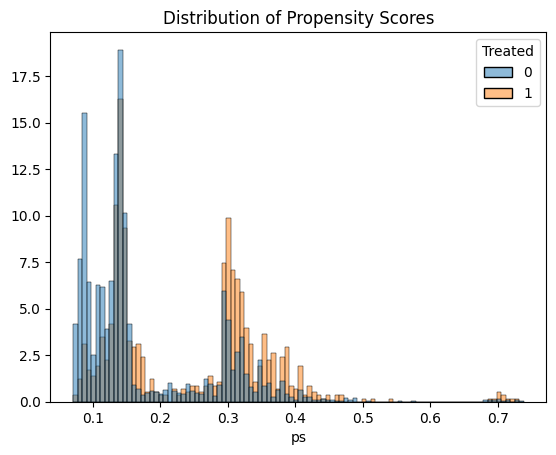

In [10]:
# Verificar graficamente a área de sobreposição
sns.histplot(data=df, x='ps', hue='Treated', bins=100, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

Agora vamos calcular os pesos IPW para o ATE e ATT.

In [11]:
# Inverse Probability of Treatment Weight (IPTW)

# Peso para o efeito médio do tratamento (ATE)
df['W1'] = 1 / df['ps']
df.loc[df['Treated'] == 0, 'W1'] = 0
df['W2'] = 1 / (1 - df['ps'])
df.loc[df['Treated'] == 1, 'W2'] = 0

# Peso para o efeito médio do tratamento nos tratados (ATT)
df['W_ATE'] = df['W1'] + df['W2']
df['W_ATT'] = df['ps'] / (1 - df['ps'])
df.loc[df['Treated'] == 1, 'W_ATT'] = 1

A título de curiosidade, podemos estimar o efeito médio do tratamento para os tratados (ATT) e o efeito médio do tratamento (ATE) utilizando o método de Ponderação pelo Escore de Propensão (IPW). Para isso, basta rodar a regressão linear considerando como peso amostral os valores de $W_{ATE}$ e $W_{ATT}$, respectivamente.

In [19]:
#Propensity Score Weighting - ATE
psw_ate = smf.wls("Y ~ Treated", weights=df['W_ATE'], data=df).fit()
print(psw_ate.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     194.9
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.03e-43
Time:                        21:04:19   Log-Likelihood:                -36594.
No. Observations:                4642   AIC:                         7.319e+04
Df Residuals:                    4640   BIC:                         7.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3401.1645     11.754    289.358      0.0

In [13]:
#Propensity Score Weighting - ATT
psw_att = smf.wls("Y ~ Treated", weights=df['W_ATT'], data=df).fit()
print(psw_att.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     155.8
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.41e-35
Time:                        16:28:39   Log-Likelihood:                -37060.
No. Observations:                4642   AIC:                         7.412e+04
Df Residuals:                    4640   BIC:                         7.414e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3350.9689     12.014    278.924      0.0

Repare que podemos obter os mesmos resultados utilizando o pacote pyDRReg.

In [17]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

IPW_att = pyDRReg(df, X_vars, T_var, Y_var, method='att', estimator='IPW', n_bootstrap=50, seed=44)

print(IPW_att.summary())

         Metric       Value
0     Estimator         IPW
1        Method         ATT
2      Estimate -213.309168
3  bootstrap_SE   22.839909
4        t-stat   -9.339318
5       p-value         0.0
6      CI Lower -258.075389
7      CI Upper -168.542946


In [15]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

IPW_ate = pyDRReg(df, X_vars, T_var, Y_var, method='ate', estimator='IPW', n_bootstrap=50, seed=44)

print(IPW_ate.summary())

         Metric       Value
0     Estimator         IPW
1        Method         ATE
2      Estimate -234.437125
3  bootstrap_SE   23.479172
4        t-stat   -9.984897
5       p-value         0.0
6      CI Lower -280.456303
7      CI Upper -188.417947


**Estimativa Duplamente Robusta**

Agora temos todos os componentes para estimar o DR para ATE e o ATT, vamos fazer "na mão".

In [17]:
# DR-ATE
DR_ATE = mu1 - mu0 + df["Treated"] / df["ps"] * (df["Y"] - mu1) - (1-df["Treated"]) / (1-df["ps"]) * (df["Y"] - mu0)
print(np.mean(DR_ATE))

-229.19546059542853


In [18]:
# DR-ATT
DR_ATT = mu1 - mu0 + df["Treated"] * (df["Y"] - mu1) - (1-df["Treated"])*df["ps"] / (1-df["ps"]) * (df["Y"] - mu0)
print(np.mean(DR_ATT))

-218.94795582708


Podemos utilizar o pacote pyDRReg para obter os mesmos resultados.

In [22]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

DR_ate = pyDRReg(df, X_vars, T_var, Y_var, method='ate', estimator='DR', n_bootstrap=50, seed=44)

print(DR_ate.summary())

         Metric       Value
0     Estimator          DR
1        Method         ATE
2      Estimate -229.195464
3  bootstrap_SE   23.584023
4        t-stat   -9.718251
5       p-value         0.0
6      CI Lower  -275.42015
7      CI Upper -182.970779


In [23]:
from pyDRReg.pyDRReg import pyDRReg

T_var = 'Treated'
Y_var = 'Y'
X_vars = ['casada', 'mage', 'medu']

DR_att = pyDRReg(df, X_vars, T_var, Y_var, method='att', estimator='DR', n_bootstrap=50, seed=44)

print(DR_att.summary())

         Metric       Value
0     Estimator          DR
1        Method         ATT
2      Estimate -218.947956
3  bootstrap_SE   22.000454
4        t-stat   -9.951974
5       p-value         0.0
6      CI Lower -262.068846
7      CI Upper -175.827066


Esse tipo de estimador é bastante importante na literatura. E já possui alguns estimadores que realizam as estimações de forma direta. Por exemplo, poderíamos computar diretamente com 'LinearDRLearner' da biblioteca 'EconML' da Microsoft (EconML - Estimate causal effects with ML).

obs: https://www.microsoft.com/en-us/research/project/econml/


In [34]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from econml.dr import LinearDRLearner

In [35]:
X = df[['casada', 'mage', 'medu']]

In [36]:
model = LinearDRLearner(model_propensity=LogisticRegression(), 
                        model_regression=LinearRegression(),
                        random_state=1)
model.fit(Y=df["Y"], T=df["Treated"], X=X);

In [37]:
model.ate_inference(X=X.values, T0=0, T1=1).summary().tables[0]

<class 'statsmodels.iolib.table.SimpleTable'>

O modelo nos dá diretamente o efeito médio do tratamento. A estimativa é estatisticamente diferente de zero e o intervalo de confiança inclui o valor verdadeiro de -229,17. Observe que obtivemos uma estimativa diferente porque a função **LinearDRLearner** também realizou o cross-fitting em segundo plano, o que não fizemos antes. Ele não calcula o ATT.

Outro pacote importante é o "causalml" (https://causalml.readthedocs.io/en/latest/about.html).



## Boas práticas

* Verifique o balanço das covariáveis.
  * Tanto o IPW quanto o DR (AIPW) foram desenvolvidos para ambientes nos quais o tratamento não é atribuído aleatoriamente incondicionalmente, mas pode depender de algumas variáveis observáveis. Essas informações podem ser verificadas de duas maneiras: 
    * (1) Produza uma tabela de médias/equilíbrio das covariáveis. Se a randomização incondicional não for válida, esperamos ver diferenças significativas entre alguns observáveis; 
    * (2) Trace os escores de propensão estimados. Se a randomização incondicional for válida, esperamos que os escores de propensão sejam constantes.
* Verifique a suposição de sobreposição.
  * Podemos simplesmente verificar os limites dos escores de propensão previstos. Se a suposição de sobreposição for violada, acabamos dividindo algum termo do estimador por zero.
